# Introduction

This is the notebook for the data analysis for the WIREs _title_ article. (doi).

The dataset was gathered by carrying out an ISI Web of Science search, and saving the results into Zotero. The Zotero API was then used to extract the data into a Pandas DataFrame, and saved into a csv file ([CCA_processed.csv](CCA_processed.csv)) for offline analysis.

The Python (3.7.x) packages required to recreate this analysis can be found in [requirements.txt](requirements.txt)

In [2]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from matplotlib import rc
from datetime import datetime
import re
import nltk
from os import path
from PIL import Image
import numpy as npx

You'll only need to run the following cell _once_.

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /Users/sth/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/sth/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import coo_matrix

The following cell contains formatting commands – you can skip or customise it.

In [4]:
rc(
    "font",
    **{
        "family": "sans-serif",
        "sans-serif": ["Helvetica"],
        "monospace": ["Inconsolata"],
        "serif": ["Baskerville"],
    }
)

rc("text", **{"usetex": True})
rc("text", **{"latex.preamble": "\\usepackage{sfmath}"})
rc("hatch", **{"linewidth": 0.45})


In [5]:
%matplotlib inline

# plot constants
dotsize = 2.
linewidth = .5
fontsize = 12

# Load the Dataframe From a Saved Version


In [6]:
df = pd.read_pickle("CCA_processed.pickle")
df.head()

,title,date,abstract,word_count,abstract_clean
0,Adaptation to Coastal Storms in Atlantic Canad...,2018-01-01,In order to improve the resilience of social-e...,162,order improve resilience social ecological sys...
1,Adaptation to Coastal Storms in Atlantic Canad...,2018-01-01,"In this chapter, we describe the methodologica...",123,chapter describe methodological approach selec...
2,"A regional, multi-sectoral and integrated asse...",2005-01-01,The 'Regional Climate Change Impact and Respon...,198,regional impact response study east anglia nor...
3,Bridging the gap: empowering decision-making f...,2006-01-01,"The methods, tools and outputs of the UK Clima...",231,method tool output uk impact programme ukcip b...
4,The Value of Linking Mitigation and Adaptation...,2009-01-01,There are two principal strategies for managin...,254,principal strategy managing risk mitigation re...


In [7]:
len(df)

258

# Utility Functions


In [10]:
def cleanup(txt, stop_words):
    """ Clean up abstract text for statistics """
    text = re.sub("[^a-zA-Z]", " ", txt)
    # Convert to lowercase
    text = text.lower()
    # Remove tags
    text = re.sub("&lt;/?.*?&gt;", " &lt;&gt; ", text)
    # Remove special characters and digits
    text = re.sub("(\\d|\\W)+", " ", text)
    text = text.split()
    # Stemming
    ps = PorterStemmer()
    # Lemmatisation
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text if not word in stop_words]
    text = " ".join(text)
    return text


def get_top_n_words(corpus, n=None):
    """ Most frequently occuring words """
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]


def get_top_n2_words(corpus, n=None):
    """ Most frequently occuring Bi-grams """
    vec1 = CountVectorizer(ngram_range=(2, 2), max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec1.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]


def get_top_n3_words(corpus, n=None):
    """ Most frequently occuring Tri-grams """
    vec1 = CountVectorizer(ngram_range=(3, 3), max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec1.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]


def sort_coo(coo_matrix):
    """ Sort co-occurrences """
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)


def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """ Get the feature names and tf-idf score of the top n items
    
    tf-idf (term frequency-inverse document frequency) is a numerical
    statistic that is intended to reflect how important a word
    is to a document in a collection or corpus.
    """

    # use only topn items from vector
    sorted_items = sorted_items[:topn]

    score_vals = []
    feature_vals = []

    # word index and corresponding tf-idf score
    for idx, score in sorted_items:

        # keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])

    # create a tuple of feature, score
    # results = zip(feature_vals,score_vals)
    results = {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]] = score_vals[idx]

    return results


def custom_bars(series, cmap):
    """ Generate custom colour bars for matplotlib """
    data_colour = [x / max(series) for x in series]
    my_cmap = plt.cm.get_cmap(cmap)
    colours = my_cmap(data_colour)
    return colours


In [11]:
# earliest and latest date criteria
start_date = datetime(2005, 1, 1)
end_date = datetime(2018, 1, 1)
mask = (df["date"] >= start_date) & (df["date"] <= end_date)


# Graph Research Effort Over Time


<Figure size 432x288 with 0 Axes>

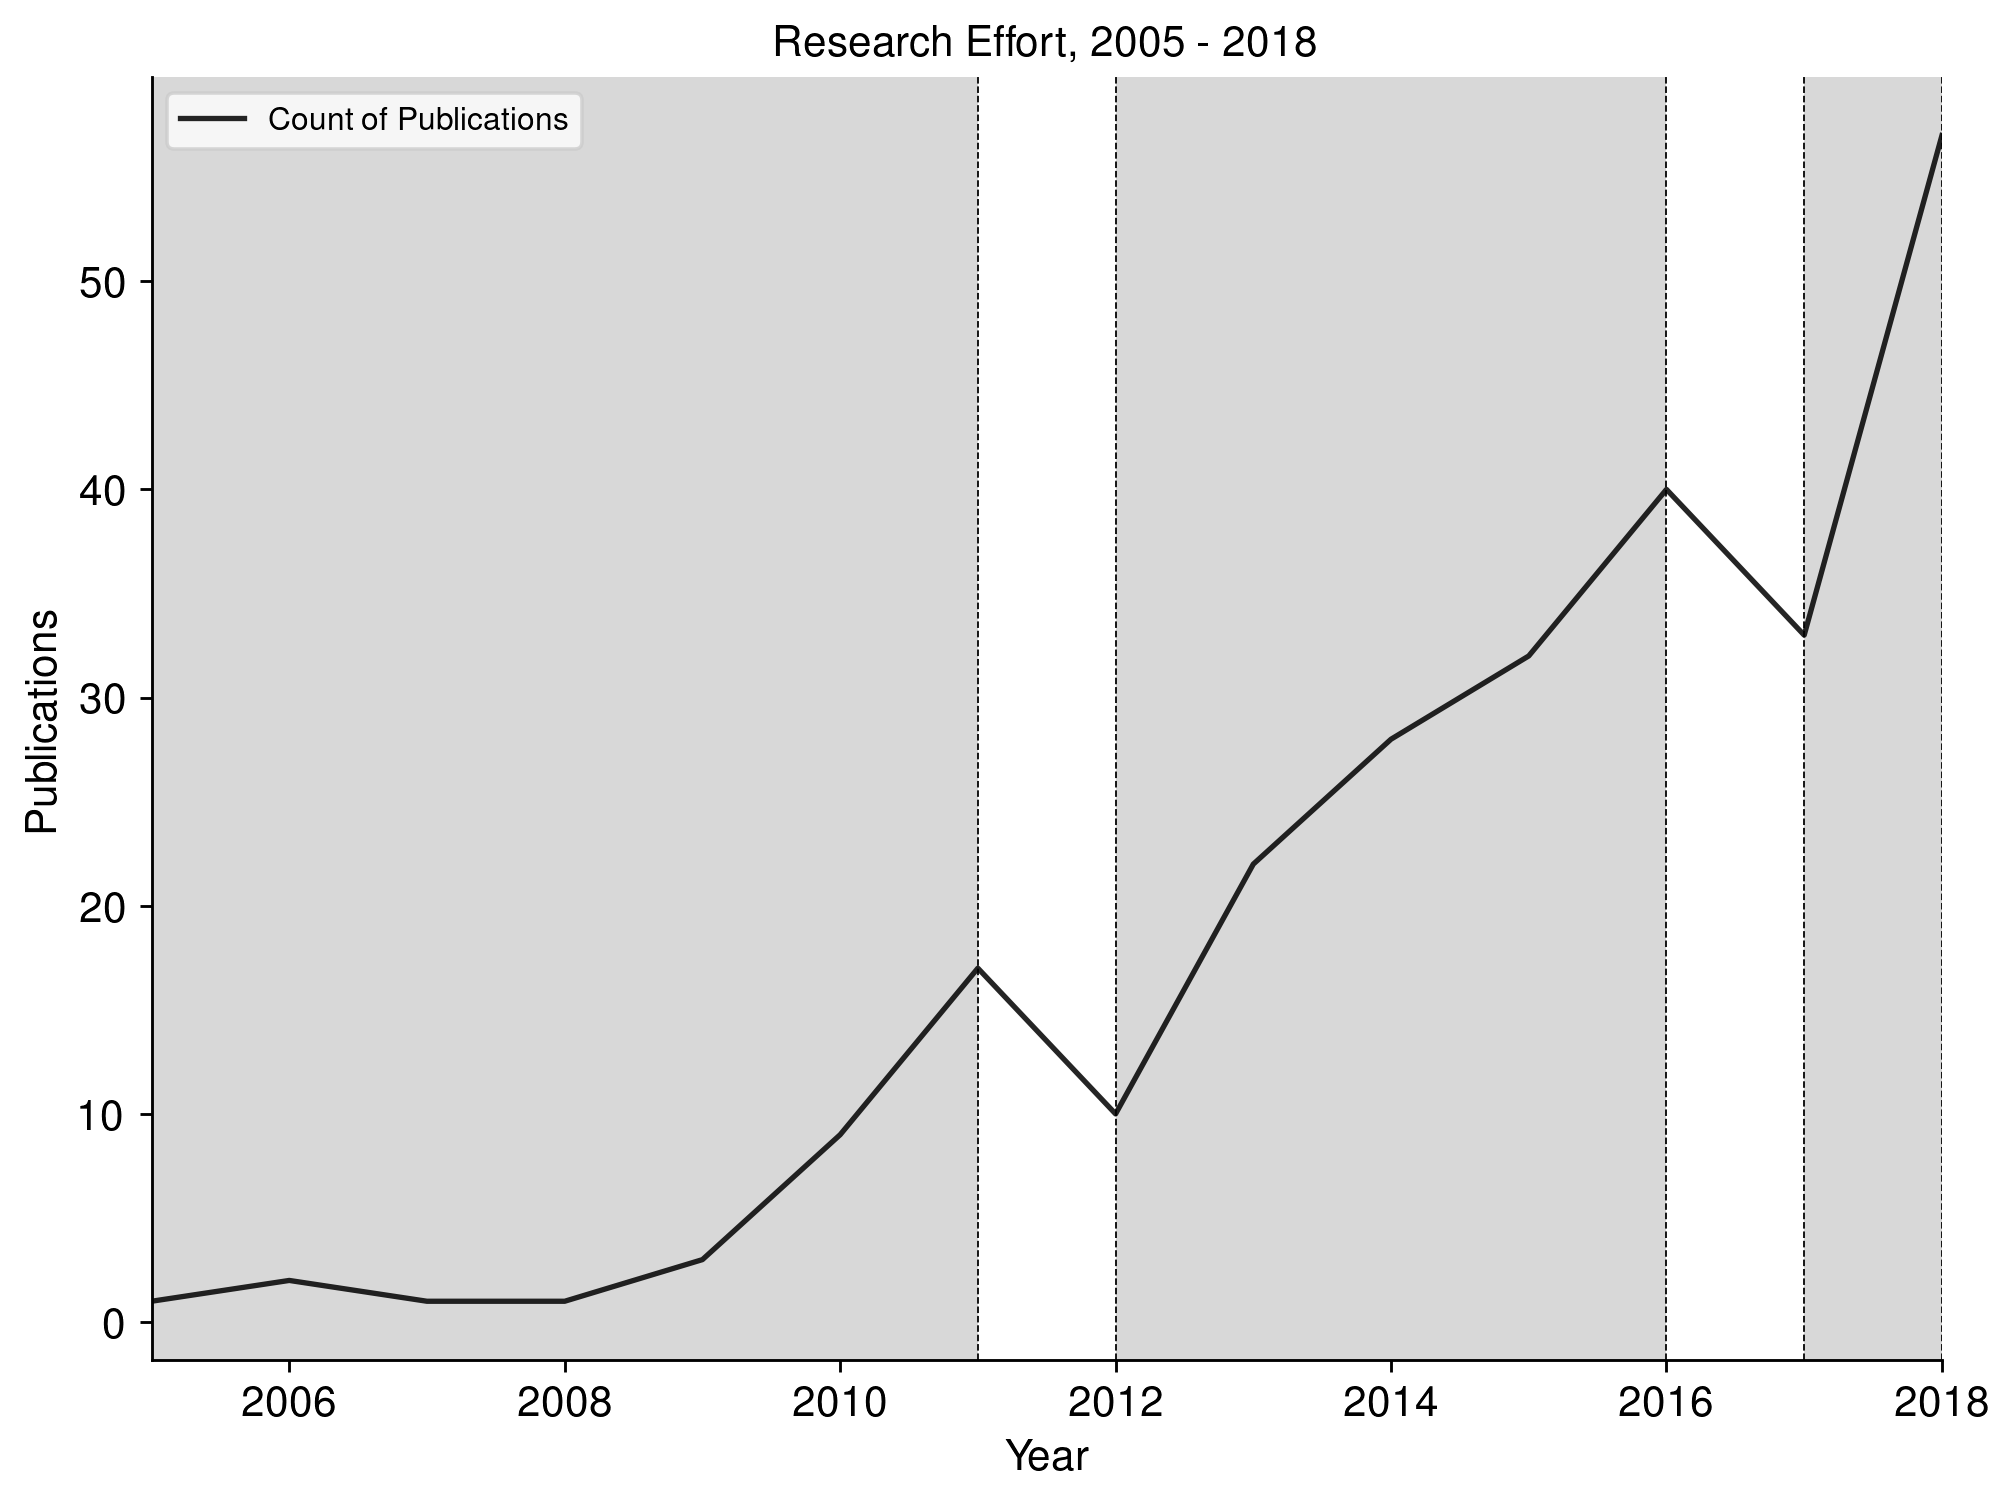

In [13]:
plt.clf()
fig, ax = plt.subplots(1, figsize=(8.0, 6.0), dpi=255)

ax.grid(b=False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_facecolor("none")
df.loc[mask].date.groupby(df.date.dt.year).agg({"count"}).plot(
    ax=ax,
    color="black",
    alpha=0.85,
    fontsize=fontsize,
)
lines = [2011, 2012, 2016, 2017, 2018]
for line in lines:
    plt.axvline(x=line, color="black", lw=0.5, linestyle="--")
plt.axvspan(2005, 2011, facecolor="grey", alpha=0.3)
plt.axvspan(2012, 2016, facecolor="grey", alpha=0.3)
plt.axvspan(2017, 2018, facecolor="grey", alpha=0.3)
leg = ax.legend(["Count of Publications"], fontsize=9)
ax.set_ylabel("Publications", fontsize=fontsize)
plt.title("Research Effort, 2005 - 2018")
ax.set_xlabel("Year", fontsize=fontsize)
plt.tight_layout()
plt.savefig("time.png", dpi=300)
plt.savefig("time.eps", dpi=300)
plt.show()


Basic stats

In [184]:
df["word_count"] = df["abstract"].apply(lambda x: len(str(x).split(" ")))
df[["abstract", "word_count"]].head()


,abstract,word_count
0,In order to improve the resilience of social-e...,162
1,"In this chapter, we describe the methodologica...",123
2,The 'Regional Climate Change Impact and Respon...,198
3,"The methods, tools and outputs of the UK Clima...",231
4,There are two principal strategies for managin...,254


In [185]:
# descriptive statistics
df.word_count.describe()


count    258.000000
mean     205.131783
std       77.624546
min        1.000000
25%      159.250000
50%      200.500000
75%      244.000000
max      600.000000
Name: word_count, dtype: float64

# Text Pre-Processing


In [96]:
# Create a list of stop words and add custom stopwords
stop_words = set(stopwords.words("english"))
# Create a list of custom stopwords
new_words = [
    "using",
    "show",
    "result",
    "large",
    "also",
    "iv",
    "one",
    "two",
    "new",
    "previously",
    "shown",
]
# these are the search keywords
new_words.extend(["climate", "change", "adaptation", "engagement", "public", "citizen"])
# these are metadata words, we definitely don't want these
new_words.extend(
    [
        "paper",
        "interest",
        "author",
        "declared",
        "conflict",
        "clim",
        "wire",
        "doi",
        "wcc",
        "ltd",
        "limited",
        "right",
        "reserved",
        "elsevier",
        "john",
        "wiley",
        "sons",
        "article",
        "please",
        "visit",
        "case",
        "study",
    ]
)
stop_words = stop_words.union(new_words)

df["abstract_clean"] = df.apply(lambda x: cleanup(x.abstract, stop_words), axis=1)


# Convert the most frequent words to a dataframe for plotting

In [97]:
top_words = get_top_n_words(df.abstract_clean, n=20)
top_df = pd.DataFrame(top_words)
top_df.columns = ["Word", "Freq"]


# Graph Most Frequent Words


<Figure size 432x288 with 0 Axes>

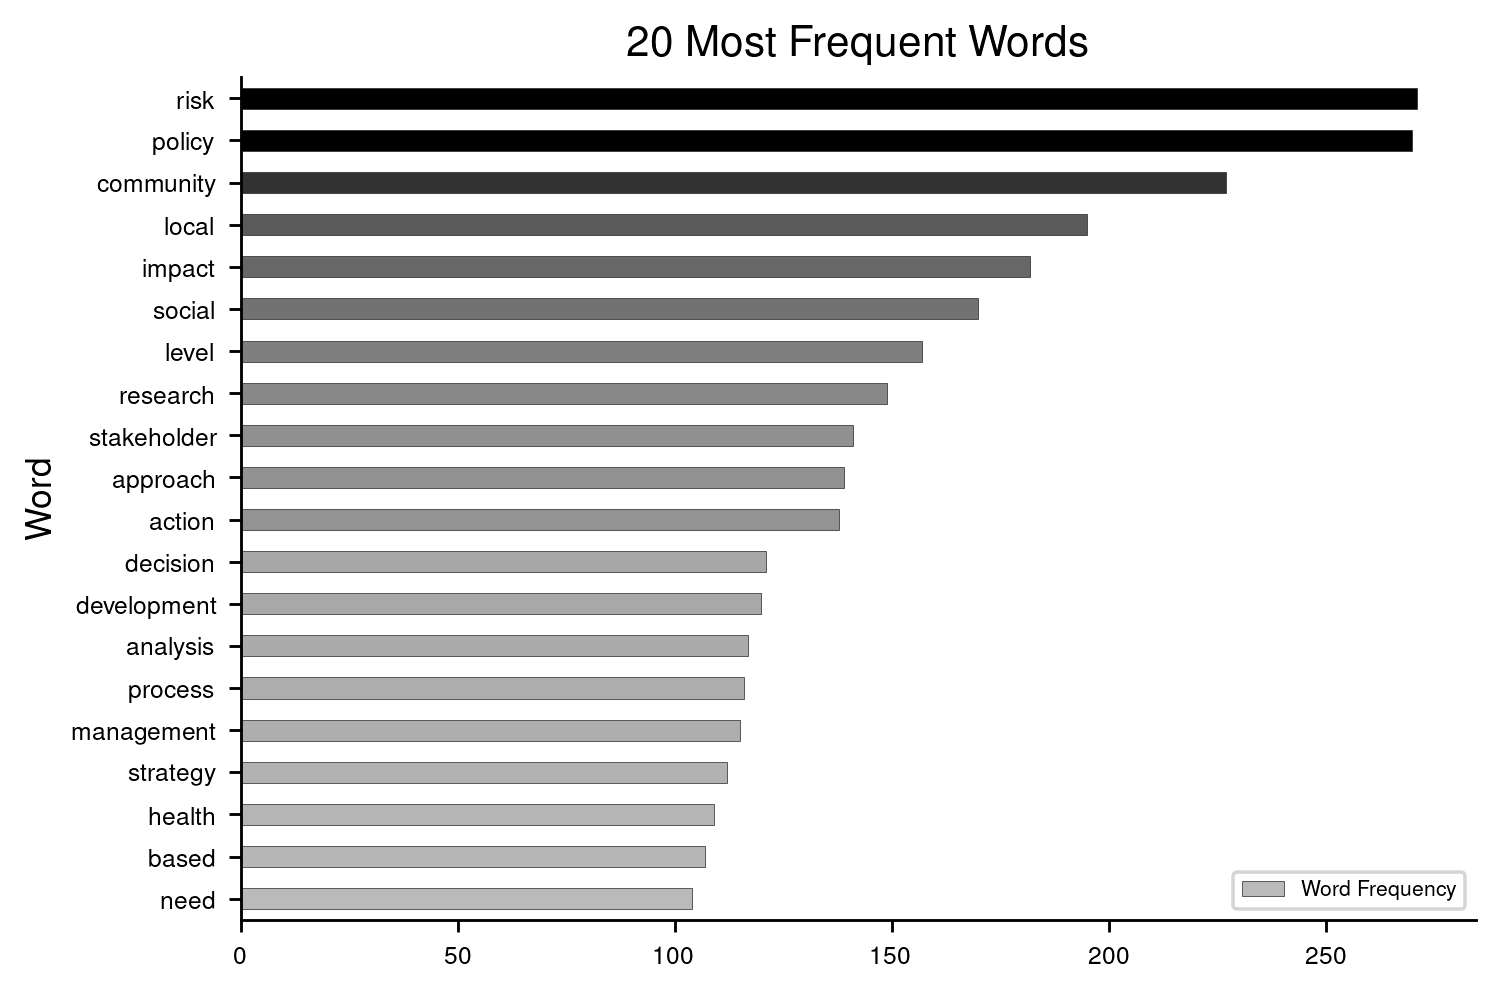

In [98]:
plt.clf()
fig, ax = plt.subplots(1, figsize=(6.0, 4.0), dpi=255)

c = custom_bars(top_df.sort_values(by=["Freq"]).Freq, "Greys")

top_df.sort_values(by=["Freq"]).plot.barh(
    ax=ax, x="Word", y="Freq", fontsize=7, color=c, edgecolor="#282828", lw=0.2
)
leg = ax.legend(["Word Frequency"], fontsize=6)
plt.title("20 Most Frequent Words")
ax.grid(b=False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_facecolor("none")
plt.tight_layout()
plt.savefig("words_single.png", dpi=300)
plt.show()


# Do the same for bigrams

In [105]:
top2_words = get_top_n2_words(df.abstract_clean, n=20)
top2_df = pd.DataFrame(top2_words)
top2_df.columns = ["Bigram", "Freq"]


<Figure size 432x288 with 0 Axes>

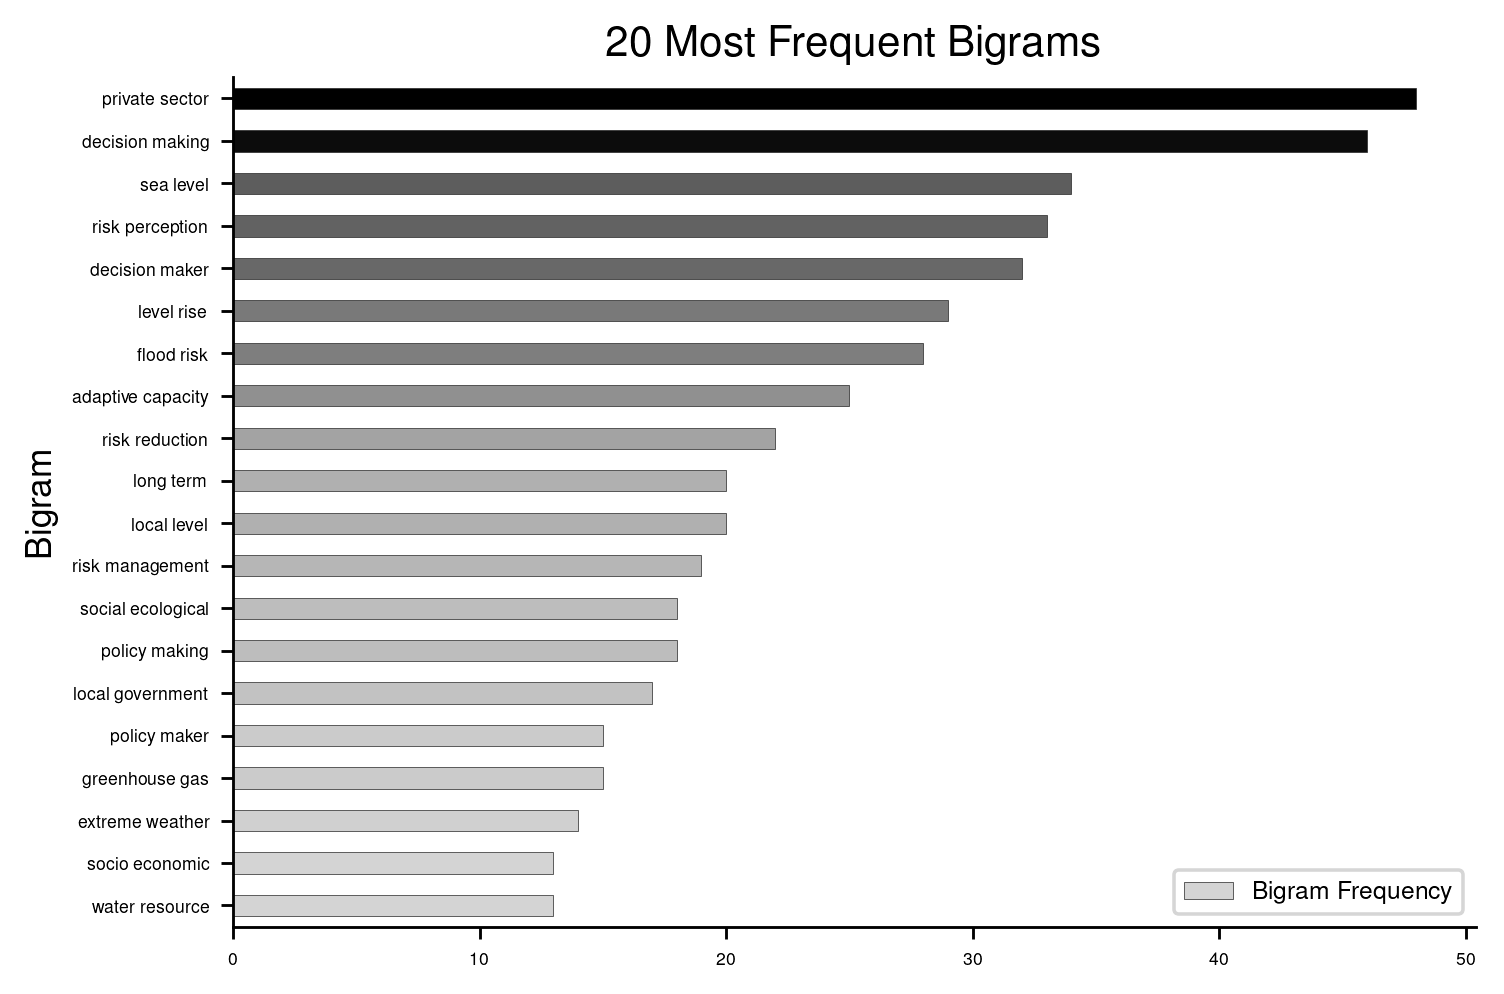

In [106]:
plt.clf()
fig, ax = plt.subplots(1, figsize=(6.0, 4.0), dpi=255)

c = custom_bars(top2_df.sort_values(by=["Freq"]).Freq, "Greys")

top2_df.sort_values(by=["Freq"]).plot.barh(
    ax=ax, x="Bigram", y="Freq", fontsize=5, color=c, edgecolor="#282828", lw=0.2
)
plt.title("20 Most Frequent Bigrams")
leg = ax.legend(["Bigram Frequency"], fontsize=7)
ax.grid(b=False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_facecolor("none")
plt.tight_layout()
plt.savefig("bigrams.png", dpi=300)
plt.show()


# …and for trigrams

In [103]:
top3_words = get_top_n3_words(df.abstract_clean, n=20)
top3_df = pd.DataFrame(top3_words)
top3_df.columns = ["Trigram", "Freq"]


<Figure size 432x288 with 0 Axes>

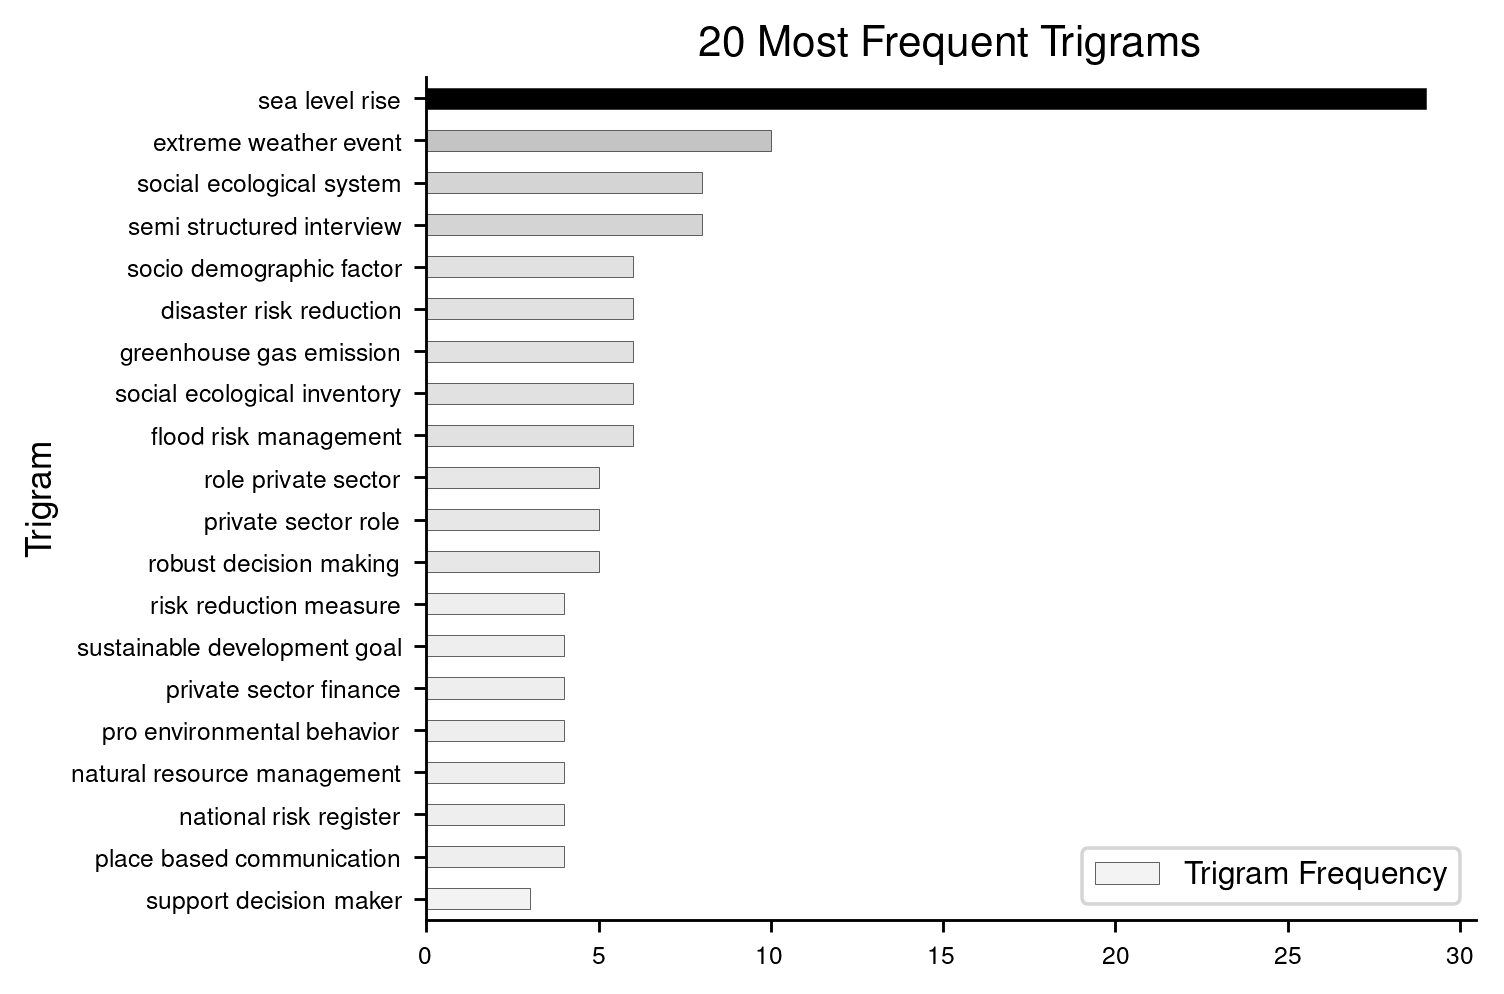

In [108]:
plt.clf()
fig, ax = plt.subplots(1, figsize=(6.0, 4.0), dpi=255)

c = custom_bars(top3_df.sort_values(by=["Freq"]).Freq, "Greys")

top3_df.sort_values(by=["Freq"]).plot.barh(
    ax=ax, x="Trigram", y="Freq", fontsize=7, color=c, edgecolor="#282828", lw=0.2
)
plt.title("20 Most Frequent Trigrams")
leg = ax.legend(["Trigram Frequency"], fontsize=9)
ax.grid(b=False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_facecolor("none")
plt.tight_layout()
plt.savefig("trigrams.png", dpi=300)
plt.show()


# Keyword Extraction

In [107]:
tfidf_transformer = TfidfTransformer(smooth_idf=True, use_idf=True)
tfidf_transformer.fit(X)
# get feature names
feature_names = cv.get_feature_names()

# fetch document for which keywords need to be extracted
doc = df.abstract_clean.iloc[50]

tf_idf_vector = tfidf_transformer.transform(cv.transform([doc]))
# sort the tf-idf vectors in descending order of scores
sorted_items = sort_coo(tf_idf_vector.tocoo())
# extract only the top n; n is 5 in this case
keywords = extract_topn_from_vector(feature_names, sorted_items, 5)


NameError: name 'X' is not defined

In [22]:
print("\nAbstract:")
print(doc)
print("\nKeywords:")
for k in keywords:
    print(k, keywords[k])



Abstract:
developing country need private sector engaged identifying risk response measure prioritize highly importance role private sector evident lesson drawn increasing amount empirical experience project supported fund successful private sector catalyse greater investment reducing vulnerability turn accelerate replication resilient technology service core development sector especially developing country investment long lived infrastructure growing rapidly private sector company integrate strategy investment economic interest well client interest interest country operate unfortunately private sector effort widely understood seen good business practice generally face several obstacle policy incentivize investment communicating risk offering incentive resilience enhancing measure necessary putting place regulation avoid shifting risk onto stronger private partnership help enhance resilience time create business opportunity private firm develop many product service enable lower cost e

# Count Occurrences of a given keyword in the corpus

In [24]:
df[df.abstract_clean.str.contains("risk")].date.groupby(df.date.dt.year).agg({"count"})


,count
date,
2008,1
2009,2
2010,3
2011,6
2012,7
2013,6
2014,10
2015,12
2016,19


# …and sum them

In [26]:
df[df.abstract_clean.str.contains("risk")].date.groupby(df.date.dt.year).agg(
    {"count"}
).sum()


count    101
dtype: int64

# Geographic Classification


In [64]:
df_countries = pd.read_excel(
    "summaries.xlsx",
    usecols=["Author", "Year", "Country", "Summary"],
)
df_countries.head()


,Author,Year,Country,Summary
0,Hedger et al.,2006,UK,What is UKCIP (UK Climate Impacts Programme)? ...
1,Moser,2006,UK,"Communicating climate change - Audiences, fram..."
2,Endfield,2007,UK,Archival exploration of climate variability an...
3,"Conlon, C",2011,US,Preventing cold-related morbidity and mortalit...
4,Hoeppner,2009,UK,Public engagement in climate change - Disjunct...


In [65]:
# clean up
df_countries["Year"] = pd.to_datetime(df_countries["Year"], format="%Y")
df_countries.dropna(inplace=True)
uniq = set(list(df_countries.Country))
print(uniq)

{'SWE', 'IRN', 'VNM', 'UGND', 'BEL', 'MAC', 'ROC', 'SA', 'AUS', 'NZ', 'NIG', 'BGDSH', 'KEN', 'INDNO', 'HK', 'SING', 'CAN', 'UK', 'IT', 'CH', 'TWN', 'IND', 'NL', 'DE', 'NO', 'DK', 'IE', 'FR', 'FI', 'BRA', 'CHIL', 'US', 'PRC', 'MAL', 'AUT', 'URG', 'JAP', 'POR'}


In [66]:
# map countries to areas
mappings = {
    "AUS": "AUS / NZ",
    "NZ": "AUS / NZ",
    "BEL": "Europe",
    "BGDSH": "Rest of World",
    "BRA": "Rest of World",
    "CAN": "North America",
    "CH": "Europe",
    "CHIL": "Rest of World",
    "DE": "Europe",
    "DK": "Europe",
    "FI": "Europe",
    "FR": "Europe",
    "HK": "Rest of World",
    "IE": "Europe",
    "IND": "Rest of World",
    "INDNO": "Rest of World",
    "IRN": "Rest of World",
    "IT": "Europe",
    "JAP": "Rest of World",
    "KEN": "Rest of World",
    "MAC": "Rest of World",
    "MAL": "Europe",
    "NIG": "Rest of World",
    "NL": "Europe",
    "NO": "Europe",
    "POR": "Europe",
    "PRC": "Rest of World",
    "ROC": "Rest of World",
    "SA": "Rest of World",
    "SING": "Rest of World",
    "SWE": "Europe",
    "TWN": "Rest of World",
    "UGND": "Rest of World",
    "UK": "UK",
    "URG": "Rest of World",
    "US": "North America",
    "VNM": "Rest of World",
}


In [67]:
# assign area by looking up countries
df_countries.Country = df_countries["Country"].astype("category")
df_countries["Area"] = df_countries["Country"].apply(lambda x: mappings.get(x))
df_countries.Area = df_countries["Area"].astype("category")
df_countries.head()


,Author,Year,Country,Summary,Area
0,Hedger et al.,2006-01-01,UK,What is UKCIP (UK Climate Impacts Programme)? ...,UK
1,Moser,2006-01-01,UK,"Communicating climate change - Audiences, fram...",UK
2,Endfield,2007-01-01,UK,Archival exploration of climate variability an...,UK
3,"Conlon, C",2011-01-01,US,Preventing cold-related morbidity and mortalit...,North America
4,Hoeppner,2009-01-01,UK,Public engagement in climate change - Disjunct...,UK


# Graph Research Effort by Area

<Figure size 432x288 with 0 Axes>

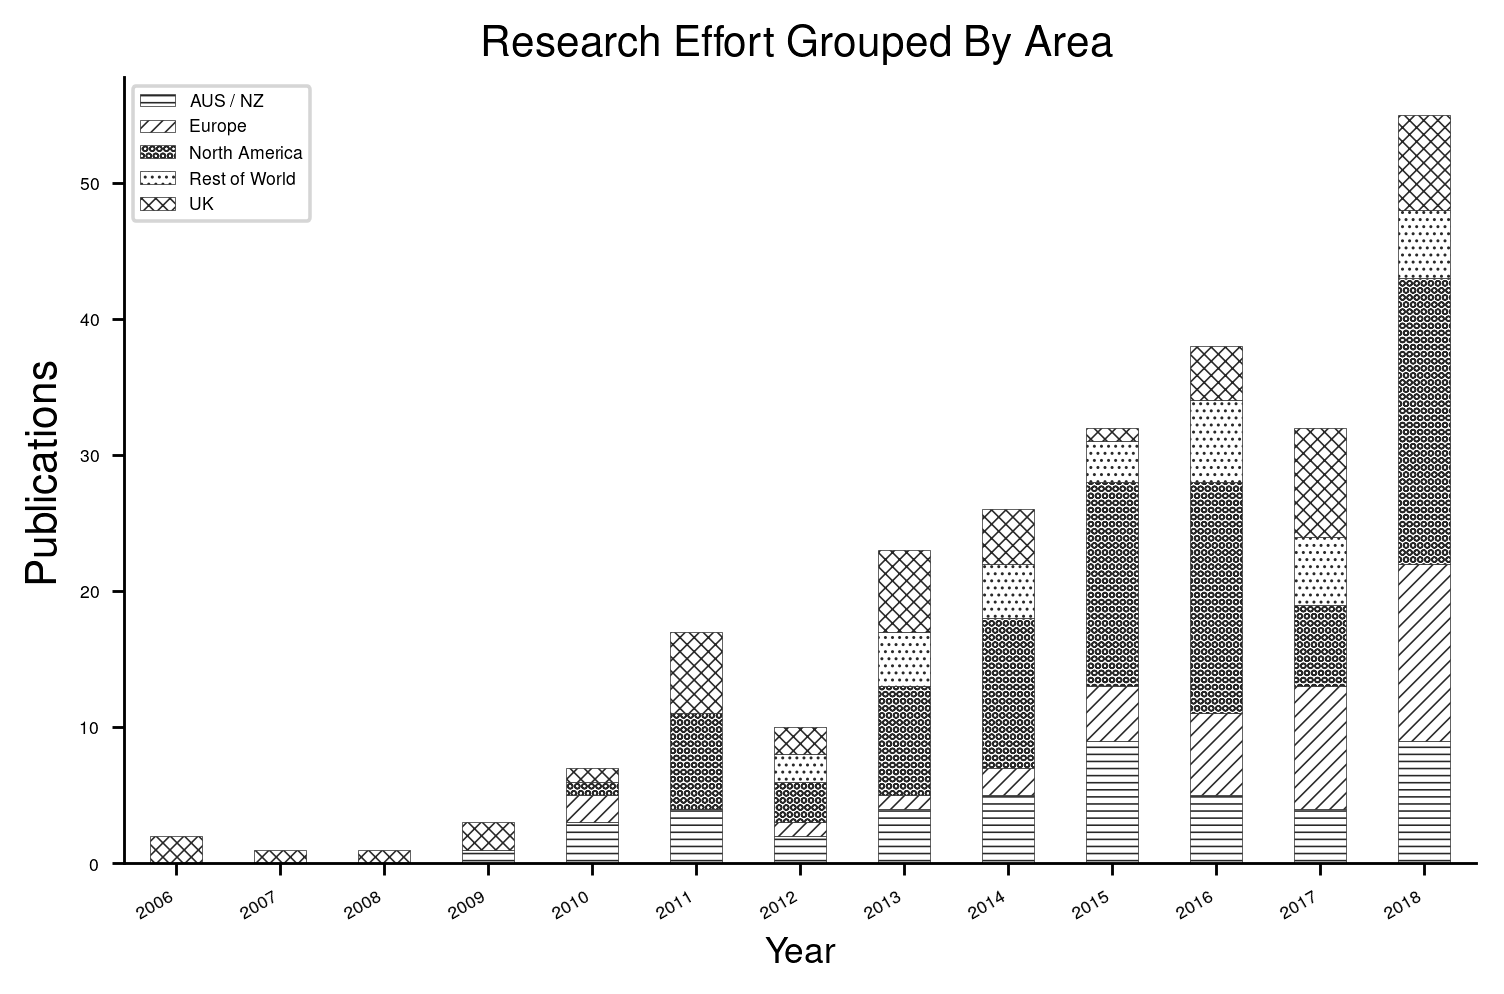

In [49]:
plt.clf()
fig, ax = plt.subplots(1, figsize=(6.0, 4.0), dpi=255)

df_countries.set_index("Year").groupby(["Year", "Area"]).count()[
    "Country"
].unstack().plot(
    kind="bar",
    stacked=True,
    fontsize=5,
    color="#ffffff",
    edgecolor="#282828",
    lw=0.2,
    ax=ax,
)
plt.title("Research Effort Grouped By Area")
ax.grid(b=False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
# manually create the tick labels, by pulling in the correct number of years
# and the lowest year value, formatted as a string
periods = len(df_countries.groupby("Year"))
ticklabels = pd.Series(
    pd.date_range(df_countries.Year.min().strftime("%Y"), freq="Y", periods=periods)
).dt.strftime("%Y")
ax.xaxis.set_major_formatter(mticker.FixedFormatter(ticklabels))
fig.autofmt_xdate()

bars = ax.patches
# the choice of hatches could be automatically derived from the number of Areas
# doing it manually gives better control over adjacent patterns (so "/" isn't adjacent to "x")
ha = [h * periods for h in "-/O.x"]
hatches = "".join(ha)
for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch * 6)
#     bar.set_color("b")
#     bar.set_edgecolor("red")
#     bar.set_facecolor("none")


ax.set_ylabel("Publications", fontsize=fontsize)
ax.legend(loc="upper left", ncol=1, fontsize=5)
ax.set_facecolor("none")
plt.tight_layout()
plt.savefig("areas.png", dpi=300)
plt.show()


# Break down research effort by year, then by area

In [73]:
ya = (
    df_countries.set_index("Year")
    .groupby(["Year", "Area"])
    .count()["Country"]
    .fillna(0)
    .astype(int)
    .unstack()
)
ya


Area,AUS / NZ,Europe,North America,Rest of World,UK
Year,,,,,
2006-01-01,0,0,0,0,2
2007-01-01,0,0,0,0,1
2008-01-01,0,0,0,0,1
2009-01-01,1,0,0,0,2
2010-01-01,3,2,1,0,1
2011-01-01,4,0,7,0,6
2012-01-01,2,1,3,2,2
2013-01-01,4,1,8,4,6
2014-01-01,5,2,11,4,4


<Figure size 432x288 with 0 Axes>

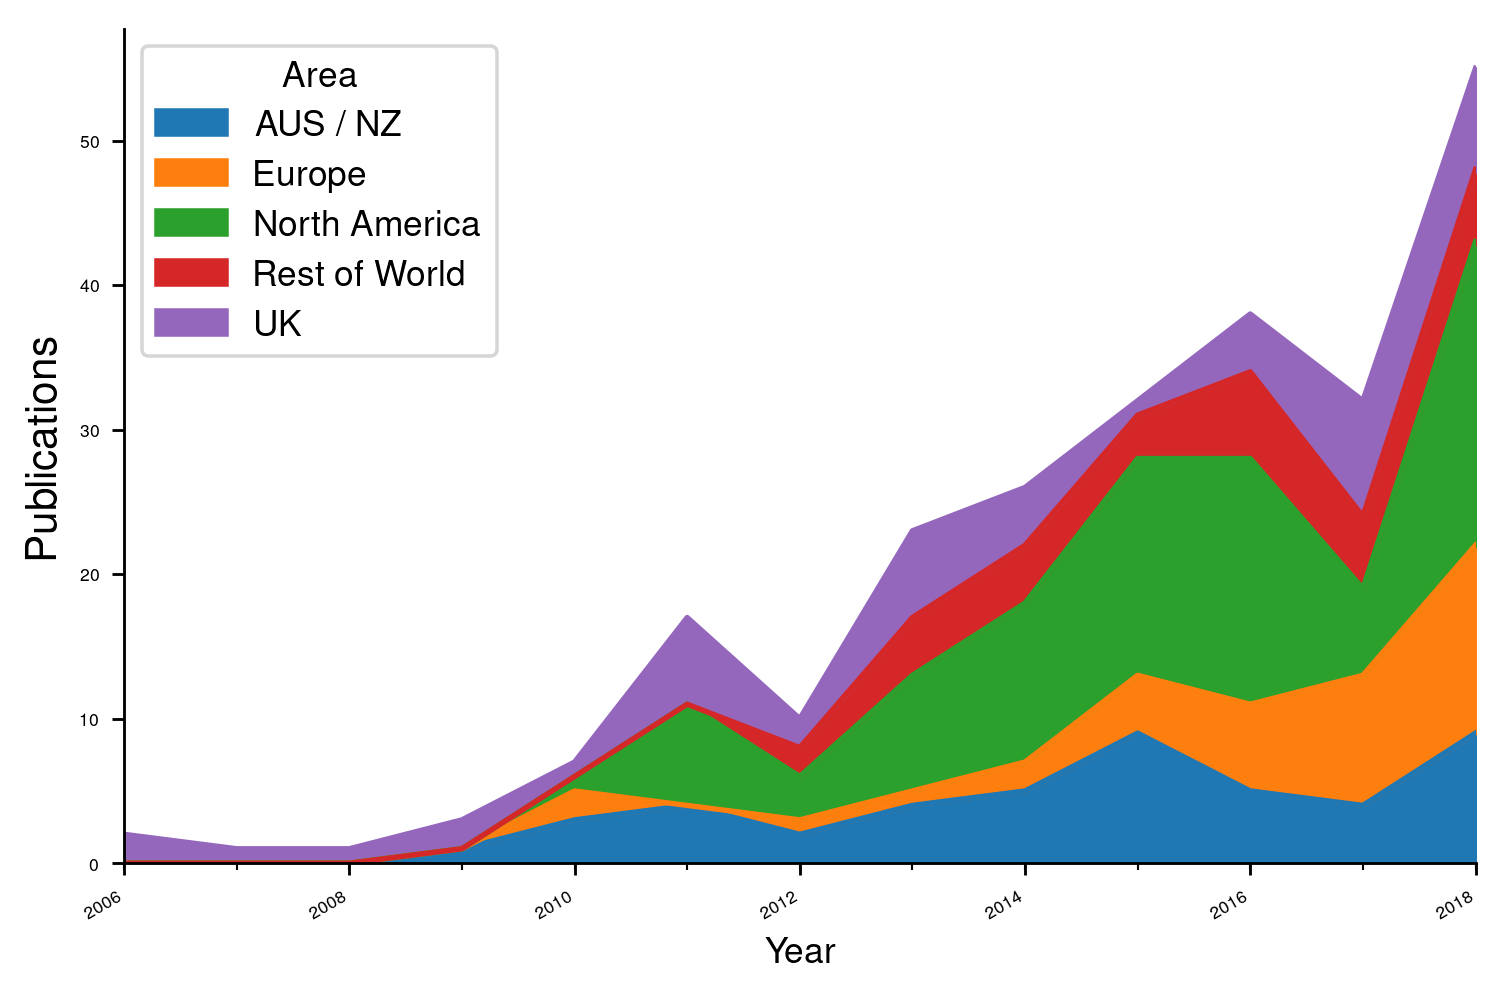

In [53]:
plt.clf()
fig, ax = plt.subplots(1, figsize=(6.0, 4.0), dpi=255)
pct = (
    df_countries.set_index("Year")
    .groupby(["Year", "Area"])
    .count()["Country"]
    .unstack()
    .plot.area(ax=ax, fontsize=5)
)
ax.grid(b=False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_ylabel("Publications", fontsize=fontsize)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()


In [56]:
# count per area, per year
pct = (
    df_countries.set_index("Year")
    .groupby(["Year", "Area"])
    .agg({"count"})
    .rename(columns={"count": "Percentage"})["Country"]
)
# percentage per area, per year
pcts = pct.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
pcts.sort_values(by=["Year", "Percentage"]).round(2)


Percentage
Year       Area                     
2006-01-01 UK                 100.00
2007-01-01 UK                 100.00
2008-01-01 UK                 100.00
2009-01-01 AUS / NZ            33.33
           UK                  66.67
2010-01-01 North America       14.29
           UK                  14.29
           Europe              28.57
           AUS / NZ            42.86
2011-01-01 AUS / NZ            23.53
           UK                  35.29
           North America       41.18
2012-01-01 Europe              10.00
           AUS / NZ            20.00
           Rest of World       20.00
           UK                  20.00
           North America       30.00
2013-01-01 Europe               4.35
           AUS / NZ            17.39
           Rest of World       17.39
           UK                  26.09
           North America       34.78
2014-01-01 Europe               7.69
           Rest of World       15.38
           UK                  15.38
           AUS / NZ            19.23
           North America       42.31
2015-01-01 UK                   3.12
           Rest of World        9.38
           Europe              12.50
           AUS / NZ            28.12
           North America       46.88
2016-01-01 UK                  10.53
           AUS / NZ            13.16
           Europe              15.79
           Rest of World       15.79
           North America       44.74
2017-01-01 AUS / NZ            12.50
           Rest of World       15.62
           North America       18.75
           UK                  25.00
           Europe              28.12
2018-01-01 Rest of World        9.09
           UK                  12.73
           AUS / NZ            16.36
           Europe              23.64
           North America       38.18

In [55]:
# Percentage per area, all years
pct = df_countries.set_index("Year").groupby(["Area"]).agg({"count"})["Country"]
pcts = pct.apply(lambda x: 100 * x / float(x.sum())).sort_values(
    by=["count"], ascending=False
)
pcts.round(2)


,count
Area,
North America,36.03
AUS / NZ,18.62
UK,18.22
Europe,15.38
Rest of World,11.74


# Find all papers which mention "risk"


In [58]:
df[df["abstract"].str.contains("risk")]


,title,date,abstract,word_count,abstract_clean
4,The Value of Linking Mitigation and Adaptation...,2009-01-01,There are two principal strategies for managin...,254,principal strategy managing risk mitigation re...
7,The New Climate Change Discourse: A Challenge ...,2010-01-01,The chapter gives an analysis of the shifting ...,196,chapter give analysis shifting social discours...
13,Community level adaptation to climate change: ...,2008-01-01,This paper explores the value of using communi...,260,explores value community risk assessment cras ...
15,Igniting change in local government: lessons l...,2009-01-01,Local governments and communities have a criti...,218,local government community critical role play ...
17,Preparing for a changing climate: The Chicago ...,2010-01-01,"The Chicago Climate Action Plan (CCAP), Chicag...",167,chicago action plan ccap chicago roadrnap redu...
19,Framing adaptation to climate-related extreme ...,2010-01-01,Whilst mitigation has dominated policy and res...,219,whilst mitigation dominated policy research ag...
21,Overview: Adaptive Management for the Health R...,2011-01-01,Climate change is expected to increase health ...,205,expected increase health risk country although...
25,Preventing cold-related morbidity and mortalit...,2011-01-01,Winter weather patterns are anticipated to bec...,206,winter weather pattern anticipated become vari...
26,New social directions in UK flood risk managem...,2011-01-01,This paper explores the evolution of a more so...,133,explores evolution sociotechnical variety floo...
27,Managed retreat of coastal communities: unders...,2012-01-01,Managed retreat - the relocation of homes and ...,202,managed retreat relocation home infrastructure...


In [8]:
df[df["abstract"].str.contains("vulnerability")]



,title,date,abstract,word_count,abstract_clean
3,Bridging the gap: empowering decision-making f...,2006-01-01,"The methods, tools and outputs of the UK Clima...",231,method tool output uk impact programme ukcip b...
4,The Value of Linking Mitigation and Adaptation...,2009-01-01,There are two principal strategies for managin...,254,principal strategy managing risk mitigation re...
12,Archival explorations of climate variability a...,2007-01-01,"In this paper, unpublished archival documentar...",229,unpublished archival documentary source used e...
13,Community level adaptation to climate change: ...,2008-01-01,This paper explores the value of using communi...,260,explores value community risk assessment cras ...
15,Igniting change in local government: lessons l...,2009-01-01,Local governments and communities have a criti...,218,local government community critical role play ...
23,Adaptation in agriculture: lessons for resilie...,2011-01-01,Assessments of adaptation in agriculture have ...,293,assessment agriculture evolved considerably ea...
24,Putting vulnerability to climate change on the...,2011-01-01,There is growing demand among stakeholders acr...,256,growing demand among stakeholder across privat...
25,Preventing cold-related morbidity and mortalit...,2011-01-01,Winter weather patterns are anticipated to bec...,206,winter weather pattern anticipated become vari...
33,Entering the Period of Consequences: The Explo...,2011-01-01,Since the early years of the twenty-first cent...,208,since early year twenty first century united s...
50,Engaging the private sector in adaptation to c...,2013-01-01,In developing countries there is a need for th...,250,developing country need private sector engaged...


In [9]:
len(df[df["abstract"].str.contains("vulnerability")])

28

<Figure size 432x288 with 0 Axes>

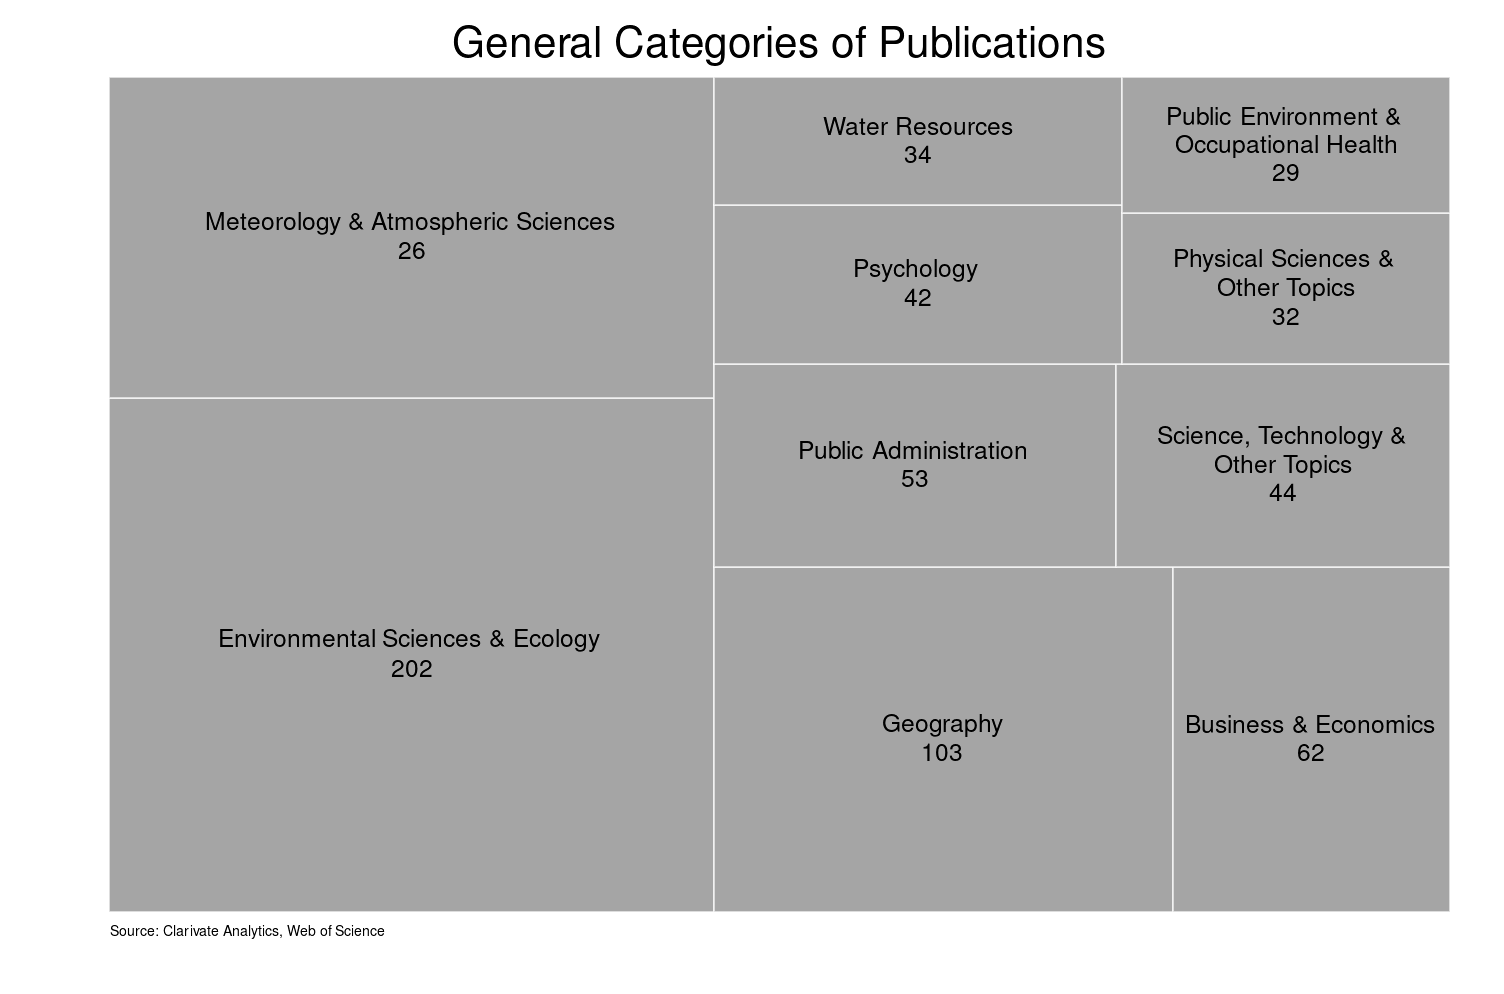

In [84]:
volume = np.array(
    [202, 126, 103, 62, 53, 44, 42, 34, 32, 29]
)

labels = [
    "Environmental Sciences \& Ecology\n202",
    "Meteorology \& Atmospheric Sciences\n26",
    "Geography\n 103",
    "Business \& Economics\n62",
    "Public Administration\n53",
    "Science, Technology \&\n Other Topics\n44",
    "Psychology\n42",
    "Water Resources\n34",
    "Physical Sciences \&\n Other Topics\n32",
    "Public Environment \&\n Occupational Health\n29"
]
colour_list = ["grey", "grey", "grey", "grey", "grey", "grey", "grey", "grey", "grey", "grey"]

plt.clf()
fig, ax = plt.subplots(1, figsize=(6.0, 4.0), dpi=255)

squarify.plot(
    ax=ax,
    sizes=volume,
    label=labels,
    color=colour_list,
    alpha=0.7,
    text_kwargs={"fontsize": 7},
    bar_kwargs={"edgecolor": "white", "linewidth": 0.5}
)
txt = "Source: Clarivate Analytics, Web of Science"
fig.text(0.08, 0.07, txt, ha='left', size=4)
plt.title("General Categories of Publications")
plt.axis("off")
plt.tight_layout()
plt.savefig("categories.png", dpi=300)
plt.show()

In [75]:
df.date.groupby(df.date.dt.year).agg(
    {"count"})

,count
date,
2005,1
2006,2
2007,1
2008,1
2009,3
2010,9
2011,17
2012,10
2013,22
